# Init

In [1]:
from IPython.display import clear_output
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Normal
from torchsummary import summary

import numpy as np
import random
from collections import deque

import struct
import socket

import matlab.engine


import matplotlib.pyplot as plt

In [2]:
global_var = {

    # Connection
    'ip_address': '127.0.0.1',                  # Ip to connect
    'port_input': 8280,                         # Port where matlab send data
    'port_output': 8281,                        # Port where matlab receive data
    'port_f_input': 8282,                       # DEPRECATED: Same but for feedback branch
    'port_f_output': 8283,                      # DEPRECATED: Same but for feedback branch
    'buffer_size': 32,                          # Number of bytes to read 
    'connection_dim_input': 4,                  # Number of data to read -> used to unpack from byte, recevied data are byte
    'connection_dim_output': 1,                 # Number of data in output -> used to pack to byte and sedn to matlab
    'stop_flag': [-999, -999, -999, -999],      # DEPRECATED
    'use_pid': True,                            # DEPRECATED
        
    # Matlab
    'matlab_path': r'C:/Users/pc/Desktop/Artificial Intellingence & Robotics/1y-2s/Intelligent and hybrid control/IHC_attidute_control/control_schemas',
    'simulation_name': 'pid_reinforcement.slx', 
    'simulation_time': 40.0,    # Time of the simulation
    'open_GUI': False,          # If True, it open the simulink schema

    # Dataset
    'max_len_dataset': 10000,

    # Feed Forward Network 
    'input_dim': 4,               # Dimension of input layer
    'output_dim': 1,              # Dimension of output layer
    'hidden_dim': 10,             # Dimension of hidden layer
    'standard_deviation': 0.1,
    'output_range': 10,           # Max control value
    'bias': False,                
    'learning_rate': 0.001,       
    'model_name': 'model.pt',     # Used to save weights
    'model_path': 'weights/',     # Folder where save weights

    # Train
    'reward_control_factor': 0.02,  # facotr which damp the control. if 0 -> r=-e^2
    'batch_size': 32,             # Batch size for training
    'start_train_size': 1,        # DEPRECATED: Minium number of sample to traine
    'n_episode': 1,                   
    'frequency_update': 32,       # Frequency update of the network
    'threshold_error': 30.0,    
    'max_reward': -5, 
    'epsilon': 0.3,  
    'max_abs_control': 5.0, 

    # Plots
    'plots_path': 'plots/'        # Folder where save plots


}

class Color:
    RED = '\033[91m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    BLUE = '\033[94m'
    MAGENTA = '\033[95m'
    CYAN = '\033[96m'
    WHITE = '\033[97m'
    RESET = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

# Architecture

## Actor-Critic Network

In [3]:
class Critic(nn.Module):
    def __init__(self, input_dim, hidden_dim, lr, bias):
        super(Critic, self).__init__()

        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.loss_fnc = nn.MSELoss()
        
        self.layer_1 = nn.Linear(
            in_features=self.input_dim,
            out_features=self.hidden_dim,
            bias=bias
        )

        
        self.layer_2 = nn.Linear(
            in_features=self.hidden_dim,
            out_features=self.hidden_dim*2,
            bias=bias
        )

        self.layer_3 = nn.Linear(
            in_features=self.hidden_dim*2,
            out_features=self.hidden_dim,
            bias=bias
        )
        
        self.layer_out= nn.Linear(
            in_features=self.hidden_dim,
            out_features=1,
            bias=bias
        )

        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    def forward(self, state):

        state = self.layer_1(state)
        state = self.tanh(state)

        state = self.layer_2(state)
        state = self.tanh(state)

        state = self.layer_3(state)
        state = self.tanh(state)

        state = self.layer_out(state)
        
        return state

In [4]:
class Actor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, lr, bias):
        super(Actor, self).__init__()


        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.loss_fnc = nn.MSELoss()
        
        
        self.layer_1 = nn.Linear(
            in_features=self.input_dim,
            out_features=self.hidden_dim,
            bias=bias
        )
        
        
        self.layer_2 = nn.Linear(
            in_features=self.hidden_dim,
            out_features=self.hidden_dim*2,
            bias=bias
        )

        self.layer_3 = nn.Linear(
            in_features=self.hidden_dim*2,
            out_features=self.hidden_dim,
            bias=bias
        )
        
        self.layer_out = nn.Linear(
            in_features=self.hidden_dim,
            out_features=self.output_dim,
            bias=bias
        )

        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    def forward(self, state):

        state = self.layer_1(state)
        state = self.tanh(state)
        
        state = self.layer_2(state)
        state = self.tanh(state)

        state = self.layer_3(state)
        state = self.tanh(state)

        state = self.layer_out(state)
        mu = self.tanh(state)*global_var['max_abs_control']

        return mu

In [5]:
class ActorCritic(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, bias, std, lr, model_name):
        super(ActorCritic, self).__init__()

        self.critic = Critic(
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            bias=bias,
            lr=lr
            )

        self.actor = Actor(
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            bias=bias,
            lr=lr
            )

        self.log_std = nn.Parameter(torch.ones(1, output_dim) * std)
        self.tanh = nn.Tanh()

        self.model_name = model_name

        self.loss_fnc = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    def forward(self, x):
        
        value = self.critic(x)
        mu    = self.actor(x)
        std = self.log_std.exp().expand_as(mu)

        action_distribution  = Normal(mu, std)
        
        action = action_distribution.sample()
        raw_log_action = action_distribution.log_prob(action) # log probability of an action given the distribution

        log_action = raw_log_action - torch.log( 1 - self.tanh(action)**2 + 1e-6  ) + torch.log( torch.tensor(global_var['max_abs_control']) )

        # In statistic  given a random variable X, a transformation Y = f(X) is another random variable,
        # the probability of Y is Py(Y) = Px( f(y)^-1 )*| D[f(y)^-1]_y |

        # the transformation of log probability with tansh is the following:
        # log( P ) = log( Pa ) - log( D[ tanh(a) ]_a ), where D[ tanh(a) ]_a = 1 - tanh(a)^2
        # log( Pa ) is the probability density of a with the normal distribution

        return action, value, action_distribution, log_action


    def save(self):
        name = self.model_name
        torch.save(self.state_dict(), name )
        #print(f"{Color.MAGENTA}Saved: {name}{Color.RESET}")

    def load(self):
        name = self.model_name
        try:
            self.load_state_dict(torch.load(name) )
            print(f"{Color.MAGENTA}loaded: {name}{Color.RESET}")
        except Exception as e:
            print(f"{Color.RED}Model not loaded{Color.RESET}")
            print(e)

# Utils


## Network

In [6]:
def setup_socket(ip_address, port_input):

    #print(f"{Color.YELLOW}ip: {ip_address}, port_input: {port_input}{Color.RESET}")

    try:
        socket_nn_input = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        socket_nn_input.bind( (ip_address, port_input) )
        socket_nn_input.listen(1)

        #print(f"{Color.BOLD}{Color.GREEN}Sockets listener created{Color.RESET}")

        return socket_nn_input
    except Exception as e:
        print(f"{Color.RED}An error occurred: {e}{Color.RESET}")

        if 'socket_nn_input' in locals():
            socket_nn_input.close()
            
        return None, None
    
def accept_connection(socket_server):
    connection, address = socket_server.accept()
    #print(f"{Color.GREEN}Connection accepted!{Color.RESET}")
    return connection, address

def receive_data(connection, buffer_size, dim_input):
    
    expected_bytes = buffer_size  # Size for one double
    no_data_flag = False
    data = b''
    while len(data) < expected_bytes:
        more_data = connection.recv(expected_bytes - len(data))

        if not more_data:
            print("\nNo data received. Ending connection.")
            no_data_flag = True
            break

        data += more_data
    data = list(struct.unpack(f'!{str(dim_input)}d', data))  # Unpack one double
    
    return data, no_data_flag

def receive_data_excpt(connection, buffer_size, dim_input, stop_flag):
    
    expected_bytes = 8# buffer_size  # Size for one double
    data = b''
    #connection.settimeout(5.0)  # Set timeout to 5 seconds

    try:
        while len(data) < expected_bytes:
            #more_data = connection.recv(expected_bytes - len(data))
            more_data = connection.recv(expected_bytes)
            if not more_data:
                # No more data is available, break the loop
                break
            data += more_data
        try:
            #data = list(struct.unpack(f'!{str(dim_input)}d', data)) 
            data = list(struct.unpack(f'!d', data)) 
        except Exception as e:
            print(f"\n{e}")
            print(f"{Color.RED}\nProblem with unpacking, error: {e}{Color.RESET}")
            print(f"{Color.RED}May be due because return empty string when nothing is receive for a certain time{Color.RESET}")
            return stop_flag
        
    except Exception as e:

        print(f"\n{e}")
        if isinstance(e, socket.timeout):
            print(f"{Color.RED}\nTimeout error: No data received within the timeout period{Color.RESET}")
        else:
            print(f"{Color.RED}\nOther exception occurred: {e}{Color.RESET}")
            print(f"{Color.RED}Maybe due to some other error in the code{Color.RESET}")
            
        print(f"{Color.RED}May be due because return empty string when nothing is receive for a certain time{Color.RESET}")
        print(f"{Color.BLUE}\nNo data received within the timeout period, maybe some error of code{Color.RESET}")
       
        return stop_flag
    
    connection.settimeout(None)
    return data

def send_data(connection, message, dim_output):
    try:
        #message_to_send = struct.pack(f'!{str(dim_output)}d', *message)  
        message_to_send = struct.pack(f'!{str(dim_output)}d', message)
        connection.sendall(message_to_send)

    except Exception as e:
        print(f"\rError sending float: {e}", end='')

def close_connections(*to_close):
    try:
        for c in to_close:
            c.close()
    except Exception as e:
        print(f"{Color.RED}\nFailed to close connection: verified the follwing error:\n{e}{Color.RESET}")
        return

    #print(f"{Color.GREEN}\nSockets closed!{Color.RESET}")


## Simulink

In [7]:
def run_simulink(model_name, matlab_path, simulation_time):

    model_name = model_name.split('.')[0]

    #print(f"\nStarting Matlab engine ... ", end='')
    future = matlab.engine.start_matlab(background=True)
    eng = future.result()  
    #print(f"Started!")

    eng.cd(matlab_path)
    #print("MATLAB working directory:", eng.pwd())

    if global_var['open_GUI'] == False:
        eng.load_system(model_name)
    else:
        eng.open_system(model_name, nargout=0)
        
    loaded_model = eng.bdroot()
    #print(f"The currently loaded model is: {loaded_model}")

    eng.set_param(model_name, 'StartTime', '0', nargout=0)
    eng.set_param(model_name, 'StopTime', str(simulation_time), nargout=0)
    eng.set_param(model_name, 'SimulationCommand', 'start', nargout=0)

    return eng

def run_simulink_with_gui(model_name, matlab_path, simulation_time):

    model_name = model_name.split('.')[0]

    #print(f"\nStarting Matlab engine ... ", end='')
    future = matlab.engine.start_matlab(background=True)
    eng = future.result()  
    #print(f"Started!")

    eng.cd(matlab_path)
    #print("MATLAB working directory:", eng.pwd())

    eng.open_system(model_name, nargout=0)
    loaded_model = eng.bdroot()

    #print(f"The currently loaded model is: {loaded_model}")

    eng.set_param(model_name, 'StartTime', '0', nargout=0)
    eng.set_param(model_name, 'StopTime', str(simulation_time), nargout=0)
    eng.set_param(model_name, 'SimulationCommand', 'start', nargout=0)

    return eng

# Setup and Train

In [8]:
def train(model, states, rewards, actions, log_action, next_states):

    # converting array of tensor inot a tensor of tensor to create the stack for the batch
    
    states = torch.stack( states, dim=0 )
    rewards = torch.stack( rewards, dim=0)
    actions = torch.stack( actions, dim=0)
    log_action = torch.stack( log_action, dim=0)
    next_states = torch.stack( next_states, dim=0)

    #states = states.view( states.shape[0], -1)
    #rewards = rewards.view( rewards.shape[0], -1)
    #actions = actions.view( actions.shape[0] , -1)
    #log_action = log_action.view( log_action.shape[0], -1)
    #next_states = next_states.view( next_states.shape[0], -1)

    model.train()

    loss = 0
    gamma = 0.99

    model.critic.optimizer.zero_grad()
    model.actor.optimizer.zero_grad()

    ##### start calculating loss #####

    #dist, values = model(states)
    _, values, _, _ = model(states)

    value_next_state = model.critic(next_states).detach()
    label = rewards + gamma * value_next_state
    delta =  label - values 

    critic_loss = model.critic.loss_fnc(delta, torch.zeros(delta.shape) ) 
    actor_loss = torch.mean(delta * log_action )
    #actor_loss = actor_loss.mean()

    #print(rewards.shape)
    #print(values.shape)
    #print(value_next_state.shape)
    #print(delta)
    #print(f"Delta: {delta.mean():.3f}, actions: {actions.mean():.3f}, log_act: {log_action.mean():.3f}, Critic: {critic_loss:.3f}, Actor: {actor_loss:.3f}")

    ##### End calculating loss #####

    actor_loss.backward(retain_graph=True)
    critic_loss.backward()

    model.critic.optimizer.step()
    model.actor.optimizer.step()

    model.save()
    model.eval()

    print()
    print("*****")
    print(f"val_state: {values.shape}, {values.mean()}")
    print(f"val_next_state: {value_next_state.shape}, {value_next_state.mean()}")
    print(f"label: {label.shape}, {label.mean()}")
    print(f"delta: {delta.shape}, {delta.mean()} -> delta^2: {delta.mean()**2}")
    print(f"log_action: {log_action.shape}, {log_action.mean()}")
    print(f"Actor_loss: {actor_loss}")
    print(f"Critic_loss: {critic_loss}")

    return actor_loss, critic_loss

In [9]:
def plot_statistics(history_error, history_desired_input, history_reference_model, history_controlled_object, history_mean_error, history_reward, name):
    time = np.linspace(0, int(global_var['simulation_time']), len(history_error))
    time_reward = np.linspace(0, int(global_var['simulation_time']), len(history_reward))

    fig, axs = plt.subplots(2,3,figsize=(18, 10))

    axs[0, 0].plot(time, history_desired_input)
    axs[0, 0].set_title('Desired input')
    axs[0, 0].grid(True)

    axs[0, 1].plot(time, history_reference_model)
    axs[0, 1].set_title('Reference model')
    axs[0, 1].grid(True)

    axs[1, 0].plot(time, history_controlled_object)
    axs[1, 0].set_title('Controlled object')
    axs[1, 0].grid(True)

    axs[1, 1].plot(time_reward, history_reward)
    axs[1, 1].set_title('Reward')
    axs[1, 1].grid(True)

    axs[0, 2].plot(time, history_error)
    axs[0, 2].set_title('Error')
    axs[0, 2].grid(True)


    axs[1, 2].plot(time, history_mean_error)
    axs[1, 2].set_title('Abs mean error - last 50')
    axs[1, 2].grid(True)


    plt.tight_layout()

    fig_name = name + '_' + 'range_' + str(global_var['max_abs_control']) + '_sim_' + global_var['simulation_name'].split('.')[0] + '_' + str(int(global_var['simulation_time']))
    print(fig_name)

    plt.grid(True)
    #plt.savefig(global_var['plots_path'] + fig_name)
    plt.show(block=False)

    
    #plt.pause(0.1)

In [10]:
def plot_loss(history_actor_loss, history_critic_loss, history_reward, history_error, name):
    
    clear_output(True)
   
    time = np.linspace(0, len(history_actor_loss) - 1, len(history_actor_loss))
    time_reward = np.linspace(0, len(history_reward) - 1, len(history_reward))
    time_error = np.linspace(0, len(history_error) - 1, len(history_error))

    fig_1, axs_1 = plt.subplots(1,2,figsize=(12, 5))
    fig_2, axs_2 = plt.subplots(1,2,figsize=(12, 5))


    history_reward = torch.stack(history_reward).detach().cpu().numpy().flatten()
    history_error = torch.stack(history_error).detach().cpu().numpy().flatten()

    axs_1[0].plot(time, history_actor_loss)
    axs_1[0].set_title('Actor loss')
    axs_1[0].grid(True)

    axs_1[1].plot(time, history_critic_loss)
    axs_1[1].set_title('Critic loss')
    axs_1[1].grid(True)

    axs_2[0].plot(time_reward, history_reward)
    axs_2[0].set_title('Reward')
    axs_2[0].grid(True)

    axs_2[1].plot(time_error, history_error)
    axs_2[1].set_title('Error')
    axs_2[1].grid(True)

    plt.tight_layout()

    # fig_name = name + '_' + 'range_' + str(global_var['max_abs_control']) + '_sim_' + global_var['simulation_name'].split('.')[0] + '_' + str(int(global_var['simulation_time']))
    # print(fig_name)

    plt.grid(True)
    #plt.savefig(global_var['plots_path'] + fig_name)
    plt.show(block=False)

    #display(plt.gcf())  # Display the current figure
    #clear_output(wait=True)  # Clear the output before the next plot
    #plt.close(fig)

    
    
    #plt.pause(0.1)

In [11]:
def compute_reward(error, control):

    error = error #/ global_var['threshold_error']
    control = control#/ global_var['max_abs_control']

    reward = abs(error) + abs(global_var['reward_control_factor']*(control.item()) )
    reward = -reward

    reward = max(reward, -abs(global_var['max_reward']) )
    
    reward = torch.tensor([reward], dtype=torch.float, requires_grad=True)

    return reward

In [12]:
def play_episode( connection_receiver, 
                  connection_sender, 
                  network, 
                  history_desired_input, 
                  history_reference_model,
                  history_controlled_object,
                  history_error,
                  history_mean_error,
                  history_reward,
                  mean_error_window,
                  train_flag
                  ):
    
    n_received = 0
    n_sent = 0
    n_train = 0
    mean_loss = 0
    n_random = 0
    actor_loss = 0.0
    critic_loss = 0.0
    penalize_flag = False
    
    states_array = []
    actions_array = []
    log_prob_array = []
    rewards_array = []
    error_array = []
    next_states_array = []

    loss_array = []
    actor_loss_array = []
    critic_loss_array = []

    while True:

        raw_data, _ = receive_data(
            connection=connection_receiver, 
            buffer_size=global_var['buffer_size'],
            dim_input=global_var['connection_dim_input']
            )
        n_received += 1
        
       
        history_controlled_object.append(raw_data[0])
        history_desired_input.append(raw_data[1])
        history_reference_model.append(raw_data[2])
        history_error.append(raw_data[-1])
        history_mean_error.append(abs(np.mean(history_error[-mean_error_window:])))
        
    
        if abs(raw_data[-1]) > global_var['threshold_error'] and n_received > 1: # end episode if diverging
            penalize_flag = True
        
        raw_data = torch.tensor(raw_data, requires_grad=False)

        if len(next_states_array) > 1 and ( len(next_states_array) % global_var['frequency_update'] ) == 0 and train_flag == True:
            
            current_loss = 0
            mean_loss = 0
            
            actor_loss, critic_loss = train(
                model=network,
                states=states_array[-global_var['frequency_update']:],
                actions=actions_array[-global_var['frequency_update']:],
                log_action=log_prob_array[-global_var['frequency_update']:],
                rewards=rewards_array[-global_var['frequency_update']:],
                next_states=next_states_array[-global_var['frequency_update']:]
            )  
            n_train += 1
            
            #mean_loss = torch.mean( torch.stack(actor_loss + critic_loss, dim=0))

            actor_loss = actor_loss.item()
            critic_loss = critic_loss.item()
            
            actor_loss_array.append(actor_loss)
            critic_loss_array.append(critic_loss)
            loss_array.append(actor_loss + critic_loss)
            
            '''
            if ( n_train % 10 ) == 0 or penalize_flag == True:
                plot_loss(
                    history_actor_loss=actor_loss_array,
                    history_critic_loss=critic_loss_array,
                    history_reward=rewards_array,
                    history_error=error_array,
                    name='Loss'
                )
            '''

            if penalize_flag == True : # end episode if diverging
                penalize_flag = False
                print(f"{Color.RED}\n---- Error too high, Restarting episode{Color.RESET}")
                raise Exception("Error too high, Restarting episode")
            
            


        with torch.no_grad():
            network_input = raw_data.unsqueeze(0)
            action, value, action_distribution, log_action = network(network_input)

            action = action.squeeze(0)
            value = value.squeeze(0)
            log_action = log_action.squeeze(0)

        
        if random.random() < global_var['epsilon'] and train_flag == True:
            action = torch.rand( action.shape )
            action = torch.clip(action, min=-global_var['max_abs_control'], max=global_var['max_abs_control'])
            action = action
            n_random += 1
        else:
            action = action
            
        current_reward = compute_reward( raw_data[-1], action )


        raw_data.requires_grad_(True)
        action.requires_grad_(True)
        current_reward.requires_grad_(True)

        if penalize_flag == True:
            #current_reward = current_reward
            current_reward = torch.tensor([ -abs(global_var['max_reward'])*2.0], dtype=torch.float, requires_grad=True)

        history_reward.append(current_reward.item())
            
        states_array.append( raw_data )
        log_prob_array.append(log_action)
        rewards_array.append( current_reward )
        error_array.append( raw_data[-1] )
        
        

        if not ( states_array == []):
            current_next_state = states_array[-1].clone()
            current_next_state.requires_grad_(True)
            next_states_array.append( current_next_state )
        
        
        
        actions_array.append( action )

        
        #print(f"raw_data: {raw_data}, shape: {raw_data.shape}")
        #print(f"log_action: {log_action}, shape: {log_action.shape}")
        #print(f"current_reward: {current_reward}, shape: {current_reward.shape}")
        #print(f"action: {action}, shape: {action.shape}")
 
    
        send_data(
            connection=connection_sender, 
            message=action.item(), 
            dim_output=global_var['connection_dim_output']
            )
        n_sent += 1

        output_line = (
            f"\rreceived: {n_received}, sent: {n_sent}, n_train: {n_train}, "
            f"error: {raw_data[-1]:.4f}, reward : {current_reward.item():.4f}" #, actor_loss: {np.mean(actor_loss_array[-mean_error_window:]) }, critic_loss: {np.mean(critic_loss_array[-mean_error_window:])}"
            f" mean_error_{str(mean_error_window)}: {np.mean(history_error[-mean_error_window:]):.4f} ,mean loss: {mean_loss:.4f}{' ' * 50}"
        )
        
        #print(output_line, end='')

In [13]:
def initialization_connection_and_simulink( ip_address, 
                                            port_input, 
                                            port_output,
                                            simulation_name,
                                            simulation_time,
                                            matlab_path
                                            ):
    receiver_socket = setup_socket(
        ip_address=ip_address, 
        port_input=port_input
        )

    send_socket = setup_socket(
        ip_address=ip_address, 
        port_input=port_output
        )
        

    #eng = run_simulink_with_gui(model_name, eng_path, simulation_time)
    
    eng = run_simulink(
        model_name=simulation_name, 
        matlab_path=matlab_path, 
        simulation_time=simulation_time
        )


    #print(f"{Color.CYAN}\nWaiting someone to connect ...{Color.RESET}")
    connection_receiver, addr = accept_connection(receiver_socket)
    connection_sender, addr = accept_connection(send_socket)

    return receiver_socket, send_socket, connection_receiver, connection_sender, eng

In [14]:
def reinforcement_training_loop(
        network,
        history_desired_input,
        history_reference_model,
        history_controlled_object,
        history_error,
        history_mean_error,
        mean_error_window,
        history_reward, 
):    
    try:

        receiver_socket, send_socket, connection_receiver, connection_sender, eng = initialization_connection_and_simulink(
                                                                                                                        ip_address=global_var['ip_address'],
                                                                                                                        port_input=global_var['port_input'],
                                                                                                                        port_output=global_var['port_output'],
                                                                                                                        simulation_name=global_var['simulation_name'],
                                                                                                                        simulation_time=global_var['simulation_time'],
                                                                                                                        matlab_path=global_var['matlab_path']
                                                                                                                    )
        play_episode_v2(
            connection_receiver=connection_receiver, 
            connection_sender=connection_sender, 
            network=network, 
            history_desired_input=history_desired_input, 
            history_reference_model=history_reference_model,
            history_controlled_object=history_controlled_object,
            history_error=history_error,
            history_mean_error=history_mean_error,
            history_reward=history_reward,
            mean_error_window=mean_error_window,
            train_flag = True
            )
       
        
    except Exception as e:
        print()
        print(e)
        pass

    finally:

        close_connections(
            connection_receiver,
            connection_sender,
            send_socket,
            receiver_socket,
        )

        eng.quit()
        pass

In [15]:
def play_reinforcement_loop(
        network,
        history_desired_input,
        history_reference_model,
        history_controlled_object,
        history_error,
        history_mean_error,
        history_reward,
        mean_error_window,
): 
    for e in range(global_var['n_episode']):
        print(f"\rn_episode: {e}\n", end="")

        history_desired_input = []
        history_reference_model = []
        history_controlled_object = []
        history_error = []
        history_mean_error = []
        history_reward = []

        reinforcement_training_loop(
                network=network,
                history_desired_input=history_desired_input,
                history_reference_model=history_reference_model,
                history_controlled_object=history_controlled_object,
                history_error=history_error,
                history_mean_error=history_mean_error,
                history_reward=history_reward,
                mean_error_window=mean_error_window,
        )

        if (e % 50) == 0:
            network.save()     
        

# PPO Algorithm 

In [41]:
def ppo_train(model, state_memory, action_memory, reward_memory, log_prog_memory, state_value_memory, next_state_memory):


    state_memory = torch.stack(state_memory, dim=0)
    action_memory = torch.stack(action_memory, dim=0)
    reward_memory = torch.stack(reward_memory, dim=0)
    log_prog_memory = torch.stack(log_prog_memory, dim=0)
    state_value_memory = torch.stack(state_value_memory, dim=0)
    next_state_memory = torch.stack(next_state_memory, dim=0)

    model.critic.optimizer.zero_grad()
    model.actor.optimizer.zero_grad()

    ### calculating loss
    delta = reward_memory + 0.99*next_state_memory - state_memory
    
    critic_loss = model.critic.loss_fnc(delta, torch.zeros(delta.shape) )
    actor_loss = -(log_prog_memory * delta.detach()).mean()

    ### optimizing
    actor_loss.backward(retain_graph=True)
    critic_loss.backward()

    model.critic.optimizer.step()
    model.actor.optimizer.step()

    model.save()
    model.eval()

    return actor_loss, critic_loss


In [50]:
def play_episode_v2( 
                    connection_receiver, 
                    connection_sender, 
                    network,
                    history_desired_input, 
                    history_reference_model,
                    history_controlled_object,
                    history_error,
                    history_mean_error,
                    history_reward,
                    mean_error_window,
                    train_flag = True
                  ):
    
    done = False
    state_memory = []
    action_memory = []
    reward_memory = []
    log_prob_memory = []
    state_value_memory = []
    next_state_memory = []

    history_actor_loss = []
    history_critic_loss = []
    history_error = []
    history_reward = []

    ### Receiving first state
    raw_state, _ = receive_data(
        connection=connection_receiver, 
        buffer_size=global_var['buffer_size'],
        dim_input=global_var['connection_dim_input']
        )
        

    state = torch.tensor( raw_state, dtype=torch.float32)

    while done == False:

        for _ in range( global_var['batch_size'] ):

            #state = torch.tensor( state, dtype=torch.float32)
            state = state.unsqueeze(0)

            ### Calculating value for this state
            action, state_value, action_distribution, log_prob = network(state)


            ### Going to the next state
            send_data(
                connection=connection_sender, 
                message=action.item(), 
                dim_output=global_var['connection_dim_output']
            )

            next_raw_data, _ = receive_data(
                connection=connection_receiver, 
                buffer_size=global_var['buffer_size'],
                dim_input=global_var['connection_dim_input']
                )
            
            next_state = torch.tensor(next_raw_data, dtype=torch.float32)

            ### check condition of termination
            if abs(next_state[-1]) > global_var['threshold_error']:
                done = True

            ### Computing rewward
            reward = compute_reward( next_state[-1], action)

            history_error.append( next_state.item()[-1] )
            history_reward.append(reward.item())


            ### adjusting dimension and appending
            state = state.squeeze(0)
            action = action.squeeze(0)
            log_prob = log_prob.squeeze(0)
            state_value = state_value.squeeze(0)

            state_memory.append(state)
            action_memory.append(action)
            reward_memory.append(reward)
            log_prob_memory.append(log_prob)
            state_value_memory.append(state_value)
            next_state_memory.append(next_state)

            ### Iterating
            state = next_state.clone().detach() 

        ### Update of network
        actor_loss, critic_loss = ppo_train(
                                            model=network,
                                            state_memory=state_memory,
                                            action_memory=action_memory,
                                            reward_memory=reward_memory,
                                            log_prog_memory=log_prob_memory,
                                            state_value_memory=state_value_memory,
                                            next_state_memory=next_state_memory
                                        )

        history_actor_loss.append( actor_loss.item() )
        history_critic_loss.append( critic_loss.item() ) 

        ### Clear memory
        state_memory = []
        action_memory = []
        reward_memory = []
        log_prob_memory = []
        state_value_memory = []
        next_state_memory = []

    if done == True : 
        print(f"{Color.RED}\n---- Error too high, Restarting episode{Color.RESET}")
        raise Exception("Error too high, Restarting episode")
            

# Main

In [18]:
network = ActorCritic(  
                        input_dim=global_var['input_dim'],
                        output_dim=global_var['output_dim'],
                        hidden_dim=global_var['hidden_dim'],
                        bias=global_var['bias'],
                        #output_range=global_var['output_range'],
                        std=global_var['standard_deviation'],
                        lr=global_var['learning_rate'],
                        model_name=global_var['model_path']+global_var['model_name']
                    )

network.eval()
#network.apply(init_weights)

ActorCritic(
  (critic): Critic(
    (relu): ReLU()
    (tanh): Tanh()
    (loss_fnc): MSELoss()
    (layer_1): Linear(in_features=4, out_features=10, bias=False)
    (layer_2): Linear(in_features=10, out_features=20, bias=False)
    (layer_3): Linear(in_features=20, out_features=10, bias=False)
    (layer_out): Linear(in_features=10, out_features=1, bias=False)
  )
  (actor): Actor(
    (relu): ReLU()
    (tanh): Tanh()
    (loss_fnc): MSELoss()
    (layer_1): Linear(in_features=4, out_features=10, bias=False)
    (layer_2): Linear(in_features=10, out_features=20, bias=False)
    (layer_3): Linear(in_features=20, out_features=10, bias=False)
    (layer_out): Linear(in_features=10, out_features=1, bias=False)
  )
  (tanh): Tanh()
  (loss_fnc): MSELoss()
)

In [19]:
# https://simple-pid.readthedocs.io/en/latest/reference.html

n_received = 0
n_sent = 0
previous_error = 0

history_desired_input = []
history_reference_model = []
history_controlled_object = []
history_error = []
history_mean_error = []
history_reward = []

mean_error_window = 50
mean_loss = 0
n_train = 0


In [51]:
play_reinforcement_loop(
        network=network,
        history_desired_input=history_desired_input,
        history_reference_model=history_reference_model,
        history_controlled_object=history_controlled_object,
        history_error=history_error,
        history_mean_error=history_mean_error,
        history_reward=history_reward,
        mean_error_window=mean_error_window,
)

n_episode: 0

a Tensor with 4 elements cannot be converted to Scalar


In [21]:
network.save()

train_range_5.0_sim_pid_reinforcement_40


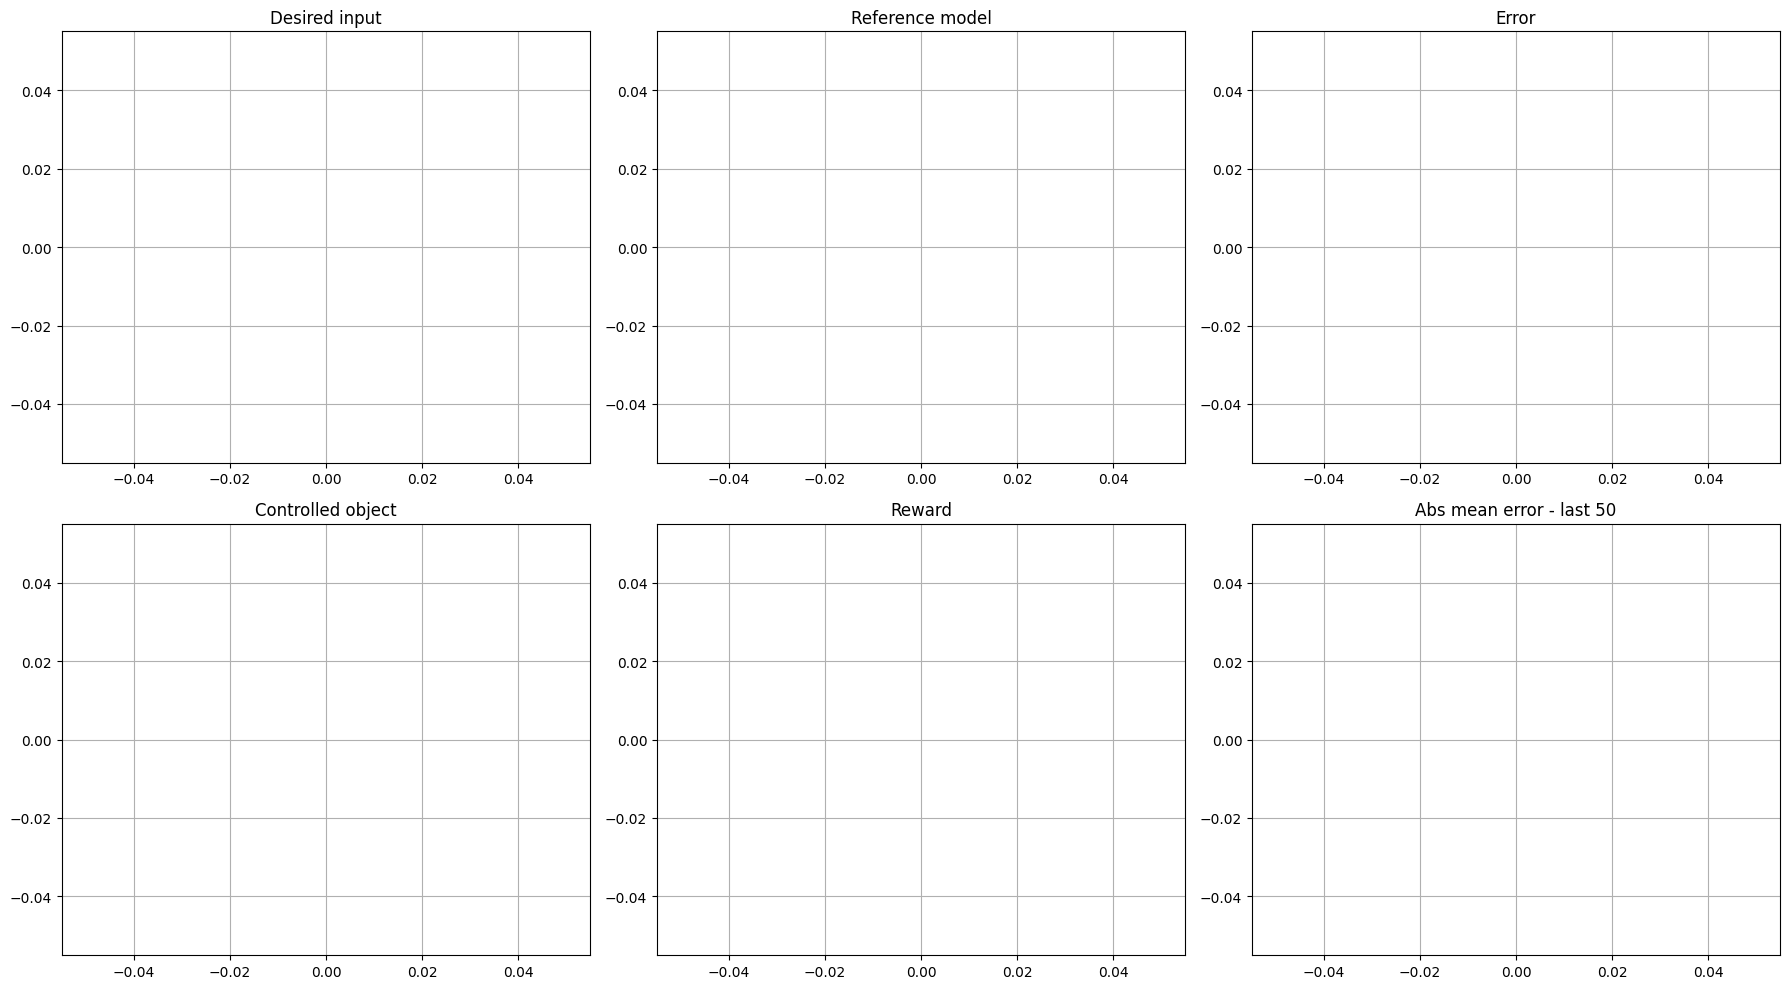

In [22]:
plot_statistics(
    history_error=history_error,
    history_desired_input=history_desired_input,
    history_reference_model=history_reference_model,
    history_controlled_object=history_controlled_object,
    history_mean_error=history_mean_error,
    history_reward=history_reward, 
    name='train'
    )